In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
from warnings import simplefilter
simplefilter("ignore")

# Import et mise en forme #

In [3]:
df_source = pd.read_csv("sources/3_residus_h_toTrain.csv")
# Renomme l'index sans nom en Date
df_source.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
# Conversion de la colonne Date de Str en DateTime
df_source["Date"] = pd.to_datetime(df_source["Date"], utc=True)\
                        .dt.tz_convert('Europe/Paris')

In [4]:
df_source.head(1)

,Date,const,trend,"s(2,24)","s(3,24)","s(4,24)","s(5,24)","s(6,24)","s(7,24)","s(8,24)",...,"sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)","sin(5,freq=A-DEC)","cos(5,freq=A-DEC)",Trend_Season_Fit,Résidus_h
0,2012-05-01 02:00:00+02:00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.848351,-0.529434,-0.051479,0.998674,0.898292,-0.4394,-0.819972,-0.572404,50912.265083,917.734917


In [5]:
# Cet import à induit un décalage horaire de +2h lors de l'attribution à la TimeZone Europe/Paris. Corriger.
df_source["Date"] = df_source["Date"] - pd.Timedelta(2, "hours")

In [6]:
df_source.head(1)

,Date,const,trend,"s(2,24)","s(3,24)","s(4,24)","s(5,24)","s(6,24)","s(7,24)","s(8,24)",...,"sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)","sin(5,freq=A-DEC)","cos(5,freq=A-DEC)",Trend_Season_Fit,Résidus_h
0,2012-05-01 00:00:00+02:00,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.848351,-0.529434,-0.051479,0.998674,0.898292,-0.4394,-0.819972,-0.572404,50912.265083,917.734917


In [7]:
df_source.tail(1)

,Date,const,trend,"s(2,24)","s(3,24)","s(4,24)","s(5,24)","s(6,24)","s(7,24)","s(8,24)",...,"sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)","sin(5,freq=A-DEC)","cos(5,freq=A-DEC)",Trend_Season_Fit,Résidus_h
102288,2023-12-31 23:00:00+01:00,1.0,102289.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,65919.087528,NaN


# Ajout de Features et Features dérivées #

### Features dérivées du champ Date ###
<i>sur la base des observations faites dans le Notebook 3_Seasonality</i>

In [8]:
df_date_components = df_source.copy()

In [9]:
# Extraction des composantes de la date
df_date_components["Mois"] = df_date_components.Date.dt.month
df_date_components["WeekOfYear"] = df_date_components.Date.dt.weekofyear
df_date_components["DayOfYear"] = df_date_components.Date.dt.day_of_year
df_date_components["DayOfWeek"] = df_date_components.Date.dt.day_of_week
df_date_components["Heure"] = df_date_components.Date.dt.hour

In [10]:
# Définition des critères de classification
# Par saison :
printemps = range(80,172)
ete = range(172,264)
automne = range(264,355)
# Par jour de la semaine (Attention, le lundi commence à 0)
weekend = range(5,7)
# Par moment de la journée
heures_pleines = range(7,14)
fin_journee = range(17,20)
nuit = range(22,6)

In [11]:
def identification_saison(DoY):
    saison="Nan"

    if DoY in printemps:
        saison = "printemps"
    elif DoY in ete:
        saison="ete"
    elif DoY in automne:
        saison="automne"
    else:
        saison="hiver"
    
    return saison

In [12]:
def identification_WE(DoW):
    jour="Nan"
    
    if DoW in weekend:
        jour="week-end"
    else:
        jour="semaine"
    
    return jour

In [13]:
def moment_journee(H):
    moment=""
    
    if H in heures_pleines:
        moment = "haute_consommation"
    elif H in fin_journee:
        moment="haute_consommation"
    elif H in nuit:
        moment="basse_consommation"
    else:
        moment="consommation_normale"
    
    return moment

In [14]:
df_date_components["Saison"] = df_date_components["DayOfYear"].apply(identification_saison)
df_date_components["Moment_semaine"] = df_date_components["DayOfWeek"].apply(identification_WE)
df_date_components["Moment_journee"] = df_date_components["Heure"].apply(moment_journee)

In [15]:
df_date_components = pd.get_dummies(df_date_components, prefix="")

### Ajout de Features Statistiques ###
<i>liées aux mesures faites au jour et à l'heure, sur la période d'entraînement</i>

In [16]:
df_date_components.columns

Index(['Date', 'const', 'trend', 's(2,24)', 's(3,24)', 's(4,24)', 's(5,24)',
       's(6,24)', 's(7,24)', 's(8,24)', 's(9,24)', 's(10,24)', 's(11,24)',
       's(12,24)', 's(13,24)', 's(14,24)', 's(15,24)', 's(16,24)', 's(17,24)',
       's(18,24)', 's(19,24)', 's(20,24)', 's(21,24)', 's(22,24)', 's(23,24)',
       's(24,24)', 'sin(1,freq=A-DEC)', 'cos(1,freq=A-DEC)',
       'sin(2,freq=A-DEC)', 'cos(2,freq=A-DEC)', 'sin(3,freq=A-DEC)',
       'cos(3,freq=A-DEC)', 'sin(4,freq=A-DEC)', 'cos(4,freq=A-DEC)',
       'sin(5,freq=A-DEC)', 'cos(5,freq=A-DEC)', 'Trend_Season_Fit',
       'Résidus_h', 'Mois', 'WeekOfYear', 'DayOfYear', 'DayOfWeek', 'Heure',
       '_automne', '_ete', '_hiver', '_printemps', '_semaine', '_week-end',
       '_consommation_normale', '_haute_consommation'],
      dtype='object')

In [17]:
df_stats = df_date_components[['DayOfYear','Heure','Trend_Season_Fit','Résidus_h']].copy()

In [18]:
df_stats = df_stats.groupby(['DayOfYear','Heure'])\
    .agg({'Résidus_h': ['mean', 'std']})

In [19]:
df_stats.reset_index(inplace=True)
# Applanissement du multindex des colonnes
df_stats.columns = ['DayOfYear','Heure','Résidus_h_mean','Résidus_h_StDev']

In [20]:
# Agrégation des Features dates + stats en 1 seul DataFrame
df_features = df_date_components.merge(df_stats, on=['DayOfYear','Heure'], how='left')

In [21]:
# Colonnes qui ne nous serviront pas pour l'entraînement
df_features.columns[1:36]

Index(['const', 'trend', 's(2,24)', 's(3,24)', 's(4,24)', 's(5,24)', 's(6,24)',
       's(7,24)', 's(8,24)', 's(9,24)', 's(10,24)', 's(11,24)', 's(12,24)',
       's(13,24)', 's(14,24)', 's(15,24)', 's(16,24)', 's(17,24)', 's(18,24)',
       's(19,24)', 's(20,24)', 's(21,24)', 's(22,24)', 's(23,24)', 's(24,24)',
       'sin(1,freq=A-DEC)', 'cos(1,freq=A-DEC)', 'sin(2,freq=A-DEC)',
       'cos(2,freq=A-DEC)', 'sin(3,freq=A-DEC)', 'cos(3,freq=A-DEC)',
       'sin(4,freq=A-DEC)', 'cos(4,freq=A-DEC)', 'sin(5,freq=A-DEC)',
       'cos(5,freq=A-DEC)'],
      dtype='object')

In [22]:
df_features.drop(columns=df_features.columns[1:36], inplace=True)

In [23]:
df_features.head(1)

,Date,Trend_Season_Fit,Résidus_h,Mois,WeekOfYear,DayOfYear,DayOfWeek,Heure,_automne,_ete,_hiver,_printemps,_semaine,_week-end,_consommation_normale,_haute_consommation,Résidus_h_mean,Résidus_h_StDev
0,2012-05-01 00:00:00+02:00,50912.265083,917.734917,5,18,122,1,0,0,0,0,1,1,0,1,0,111.554259,3150.53338


# Entraînement #

In [24]:
import optuna

Optuna est utilisé pour recherche des meilleurs paramètres.<br/>
Documentation : https://optuna.org/#code_examples

In [25]:
# On peut éventuellement changer le ratio 80/20, ou changer la période d'observation
# Mais il faudra privilégier un découpage qui focalise l'entraînement sur les pics hivernaux
features_train = df_features.loc[ df_features.Date < "2020-06-01 00:00:00"]\
    .drop(columns=["Date","Résidus_h"])

features_test = df_features.loc[ (df_features.Date >= "2020-06-01 00:00:00") & (df_features.Date < "2022-06-01 00:00:00")]\
    .drop(columns=["Date","Résidus_h"])

In [26]:
print("ration train test : {} %".format( int((features_train.shape[0] / (features_train.shape[0]+features_test.shape[0]))*100 ) ) )

ration train test : 80 %


In [27]:
target_train = df_features.loc[ df_features.Date < "2020-06-01 00:00:00"]["Résidus_h"]
target_test = df_features.loc[ (df_features.Date >= "2020-06-01 00:00:00") & (df_features.Date < "2022-06-01 00:00:00")]["Résidus_h"]

In [28]:
def objective(trial):
    
    train_x = features_train
    train_y = target_train
    test_x = features_test
    test_y = target_test

    param = {
        'metric': 'mae', 
        'boosting_type' : 'goss',
        'random_state': 1337,
        'n_estimators': 40000,
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 100.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 100.0),
        #'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        #'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [4,6,8,10]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 500),
        'min_child_samples': trial.suggest_int('min_child_samples', 100, 1000),
        #'cat_smooth' : trial.suggest_int('min_data_per_groups', 1, 100)
    }
    model = LGBMRegressor(**param)  
    
    model.fit(train_x, train_y, eval_set=[(test_x,test_y)], early_stopping_rounds=100, verbose=False)
    
    preds = model.predict(test_x)
    
    # Si squared = True, retourne MSE
    #rmse = mean_squared_error(test_y, preds,squared=False)
    mae = mean_absolute_error(test_y, preds)
    
    return mae

In [29]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)

print('Entraînement terminé :', len(study.trials))
print('Meilleur entraînement :', study.best_trial.params)

[I 2022-08-01 13:43:22,620] A new study created in memory with name: no-name-bbb6c63c-563d-4ccc-b74d-f794c5009b30
[I 2022-08-01 13:43:23,480] Trial 0 finished with value: 2852.4245531255883 and parameters: {'reg_alpha': 3.9125590307433753, 'reg_lambda': 0.0022727998345066225, 'learning_rate': 0.02, 'max_depth': 6, 'num_leaves': 428, 'min_child_samples': 843}. Best is trial 0 with value: 2852.4245531255883.
[I 2022-08-01 13:43:27,186] Trial 1 finished with value: 2844.6065578727334 and parameters: {'reg_alpha': 9.366881576662822, 'reg_lambda': 0.004196423619508917, 'learning_rate': 0.01, 'max_depth': 6, 'num_leaves': 171, 'min_child_samples': 465}. Best is trial 1 with value: 2844.6065578727334.
[I 2022-08-01 13:43:29,448] Trial 2 finished with value: 2872.7364322364865 and parameters: {'reg_alpha': 0.0018874317402412478, 'reg_lambda': 0.9048939869409613, 'learning_rate': 0.014, 'max_depth': 6, 'num_leaves': 8, 'min_child_samples': 487}. Best is trial 1 with value: 2844.6065578727334.
[

Entraînement terminé : 25
Meilleur entraînement : {'reg_alpha': 0.12087824227228582, 'reg_lambda': 0.049550637812034885, 'learning_rate': 0.01, 'max_depth': 6, 'num_leaves': 248, 'min_child_samples': 244}


In [30]:
#Visualize parameter importances.
optuna.visualization.plot_param_importances(study)

In [31]:
params = study.best_params
params

{'reg_alpha': 0.12087824227228582,
 'reg_lambda': 0.049550637812034885,
 'learning_rate': 0.01,
 'max_depth': 6,
 'num_leaves': 248,
 'min_child_samples': 244}

In [32]:
model = LGBMRegressor(**params)
%time model.fit(features_train, target_train)

CPU times: total: 3 s
Wall time: 627 ms


LGBMRegressor(learning_rate=0.01, max_depth=6, min_child_samples=244,
              num_leaves=248, reg_alpha=0.12087824227228582,
              reg_lambda=0.049550637812034885)

In [33]:
%time y_test = model.predict(features_test)
predictions = pd.Series(data=y_test, index=features_test.index, name='Prédictions_Résidus_test')

CPU times: total: 281 ms
Wall time: 53.5 ms


In [34]:
mse = mean_squared_error(target_test, predictions)
rmse = mse**(0.5)
mae = mean_absolute_error(target_test, predictions)
print("RMSE :", int(rmse))
print("MAE :", int(mae))

RMSE : 4229
MAE : 3067


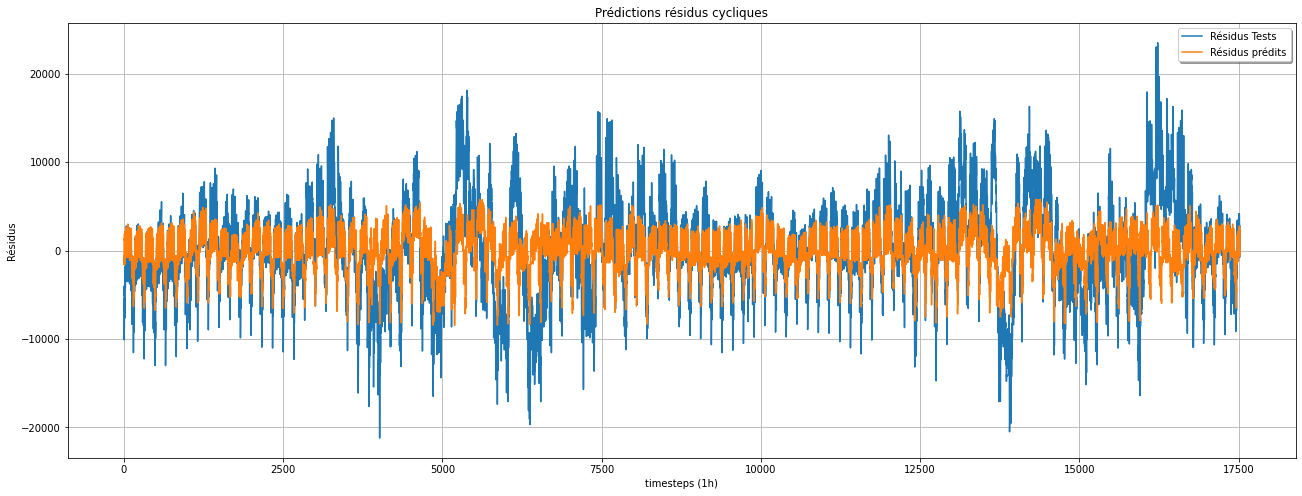

In [35]:
x_ax = range(len(target_test))
plt.figure(figsize=(22, 8))
plt.plot(x_ax, target_test, label="Résidus Tests")
plt.plot(x_ax, predictions, label="Résidus prédits")
plt.title("Prédictions résidus cycliques")
plt.xlabel('timesteps (1h)')
plt.ylabel('Résidus')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

On constate que les prédictions positives ou négatives semblent bien suivie.<br/>
Néanmoins en cas d'emballement, on remarque que l'algorithme ne semble pas être en mesure de dépasser un certain seuil.<br/>
Ces pics semblent être traités, à juste titre, d'outliers. On peut alors aider l'agorithme en ajoutant 1 écart type à ces périodes.

In [36]:
mois_hiver = df_features.loc[ df_features._hiver == 1].index
mois_ete = df_features.loc[ df_features._ete == 1].index

In [37]:
%time y_test = model.predict(features_test)
predictions = pd.Series(data=y_test, index=features_test.index, name='Prédictions_Résidus_test')

CPU times: total: 250 ms
Wall time: 55.4 ms


In [38]:
# Prédiction ajustée de +/- 1 écart type
# Attention ici les index ne commencent pas à 0, on est sur la partie de Test
for i in range(70872, 88392):
    if (i not in mois_ete) and (predictions[i] >= 5000) :
        predictions[i] = predictions[i] + df_features['Résidus_h_StDev'][i]*0.66
    #elif (i in mois_hiver) and (predictions[i] <= -10000) :
    #    predictions[i] = predictions[i] - df_features['Résidus_h_StDev'][i]*0.66


In [39]:
mse = mean_squared_error(target_test, predictions)
rmse = mse**(0.5)
mae = mean_absolute_error(target_test, predictions)
print("RMSE :", int(rmse))
print("MAE :", int(mae))

RMSE : 4224
MAE : 3062


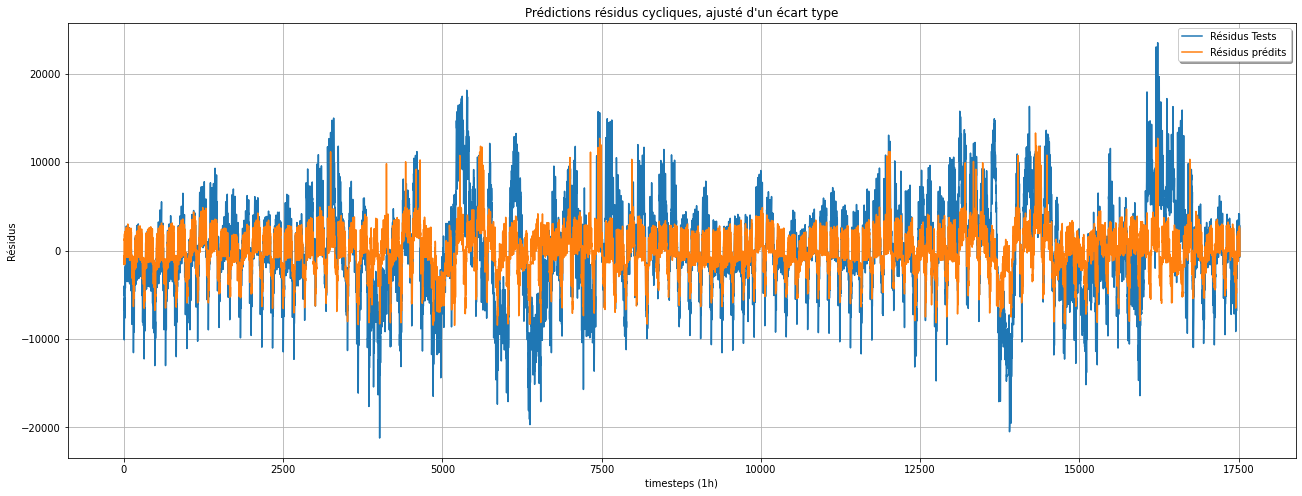

In [40]:
x_ax = range(len(target_test))
plt.figure(figsize=(22, 8))
plt.plot(x_ax, target_test, label="Résidus Tests")
plt.plot(x_ax, predictions, label="Résidus prédits")
plt.title("Prédictions résidus cycliques, ajusté d'un écart type")
plt.xlabel('timesteps (1h)')
plt.ylabel('Résidus')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

On a un MAE légèrement plus elévé, mais qui capte mieux les pics. Ce que l'on cherche.<br/>
Application désormais à l'horizon de prédiction 2024

In [41]:
X_forecast = df_features.loc[ df_features.Date >= "2022-06-01 00:00:00"]\
    .drop(columns=["Date","Résidus_h"])

In [42]:
%time _predictions_fore = model.predict(X_forecast)
predictions_fore = pd.Series(data=_predictions_fore, index=X_forecast.index, name='Forecast_Résidus')

CPU times: total: 188 ms
Wall time: 28.4 ms


In [43]:
# Identifier l'index min et max de la Série, pour la boucle For suivante
predictions_fore

88392     1443.694459
88393      124.127314
88394      959.117143
88395      374.041329
88396      478.011065
             ...     
102284   -5967.133459
102285   -5967.133459
102286   -5756.201527
102287   -5607.961089
102288   -5295.432766
Name: Forecast_Résidus, Length: 13897, dtype: float64

In [44]:
# Prédiction ajustée de +/- 1 écart type en période hivernale
# Attention ici les index ne commencent pas à 0, on est sur la partie de Test
for i in range(88392, 102289):
    if (i in mois_hiver) and (predictions_fore[i] >= 4000) :
        predictions_fore[i] = predictions_fore[i] + df_features['Résidus_h_StDev'][i]*0.75
    elif (i in mois_hiver) and (predictions_fore[i] <= -8000) :
        predictions_fore[i] = predictions_fore[i] - df_features['Résidus_h_StDev'][i]


# Affichage du résultat final #
Et interprétation sur la survenue des prochains pics

### Import et mise en forme, données de mesures originelles ###

In [45]:
df_raw_data = pd.read_csv("sources/1_conso_energies_raff.csv")

In [46]:
df_raw_data.head(1)

,Date,Conso_gaz_totale_MW,Conso_elec_totale_MW,Statut,Conso_brute_totale_MW,MA_max_7j
0,2012-01-01 00:00:00+01:00,55353.0,59610.0,Définitif,114963.0,76698.0


In [47]:
df_raw_data["Date"] = pd.to_datetime(df_raw_data["Date"], utc=True)\
                        .dt.tz_convert('Europe/Paris')

In [48]:
df_raw_data.head(1)

,Date,Conso_gaz_totale_MW,Conso_elec_totale_MW,Statut,Conso_brute_totale_MW,MA_max_7j
0,2012-01-01 00:00:00+01:00,55353.0,59610.0,Définitif,114963.0,76698.0


In [49]:
df_raw_data = df_raw_data.groupby(pd.Grouper(key='Date', axis=0, freq='H'))\
    .max()

In [50]:
df_raw_data.isna().sum()

Conso_gaz_totale_MW      10
Conso_elec_totale_MW     10
Statut                   10
Conso_brute_totale_MW    10
MA_max_7j                10
dtype: int64

In [51]:
df_raw_data.interpolate(method='linear', axis=0, inplace=True)

In [52]:
df_raw_data.head(1)

,Conso_gaz_totale_MW,Conso_elec_totale_MW,Statut,Conso_brute_totale_MW,MA_max_7j
Date,,,,,
2012-01-01 00:00:00+01:00,55398.5,59610.0,Définitif,114963.0,76698.0


In [53]:
df_raw_data.reset_index(inplace=True)

### Jointure des DataFrames de mesure, Entraînement, Test et Prédictions ouf of sample ###

In [54]:
df_resultat = df_features[['Date','Trend_Season_Fit']].copy()

In [55]:
# Agrégation 1, entre les mesures sur la période 2012-2022
# + le forecast saison & tendance jusqu'à 2024
df_resultat = df_resultat.merge(df_raw_data[['Date','Conso_elec_totale_MW']], on='Date', how='left')

In [56]:
df_resultat.head(1)

,Date,Trend_Season_Fit,Conso_elec_totale_MW
0,2012-05-01 00:00:00+02:00,50912.265083,51830.0


In [57]:
# Et enfin jointure avec les prédictions jusqu'à 2024 des résidus
# NB : on concatène les résidus d'entrainement, donc exacts, avec les résidus prédits sur la période d'entraînement
# Bien que l'on ait les valeurs rélles sur cette période
# Et enfin on ajoute les résidus out of sample, 2022 -> 2024
forecast_résidus = list(target_train) + list(predictions) + list(predictions_fore)

In [58]:
df_resultat["Résidus"] = forecast_résidus

In [59]:
# La prédiction finale est la somme des prédictions sur transformées de Fourrier + Prédiction des résidus
df_resultat["Forecasted_values"] = df_resultat["Résidus"] + df_resultat["Trend_Season_Fit"]

In [60]:
df_resultat.head()

,Date,Trend_Season_Fit,Conso_elec_totale_MW,Résidus,Forecasted_values
0,2012-05-01 00:00:00+02:00,50912.265083,51830.0,917.734917,51830.0
1,2012-05-01 01:00:00+02:00,47674.780772,46873.0,-801.780772,46873.0
2,2012-05-01 02:00:00+02:00,45241.863581,46140.0,898.136419,46140.0
3,2012-05-01 03:00:00+02:00,43565.911168,43495.0,-70.911168,43495.0
4,2012-05-01 04:00:00+02:00,41659.919025,41246.0,-413.919025,41246.0


Data Viz

In [61]:
# Apparence graphes Matplotlib
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(22, 8))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

In [62]:
df_resultat_viz = df_resultat.loc[df_resultat.Date >= "2017-06-01 00:00:00"]
df_entrainement_modele = df_resultat.loc[ (df_resultat.Date >= "2020-06-01 00:00:00") & (df_resultat.Date < "2022-06-01 00:00:00")]
df_predictions_modele = df_resultat.loc[ df_resultat.Date >= "2022-06-01 00:00:00" ]

In [75]:
# Passage des dates en index, afin qu'elles soient affichées sur l'axe X au prochain graphe
df_resultat_viz.set_index('Date', inplace=True)
df_entrainement_modele.set_index('Date', inplace=True)
df_predictions_modele.set_index('Date', inplace=True)

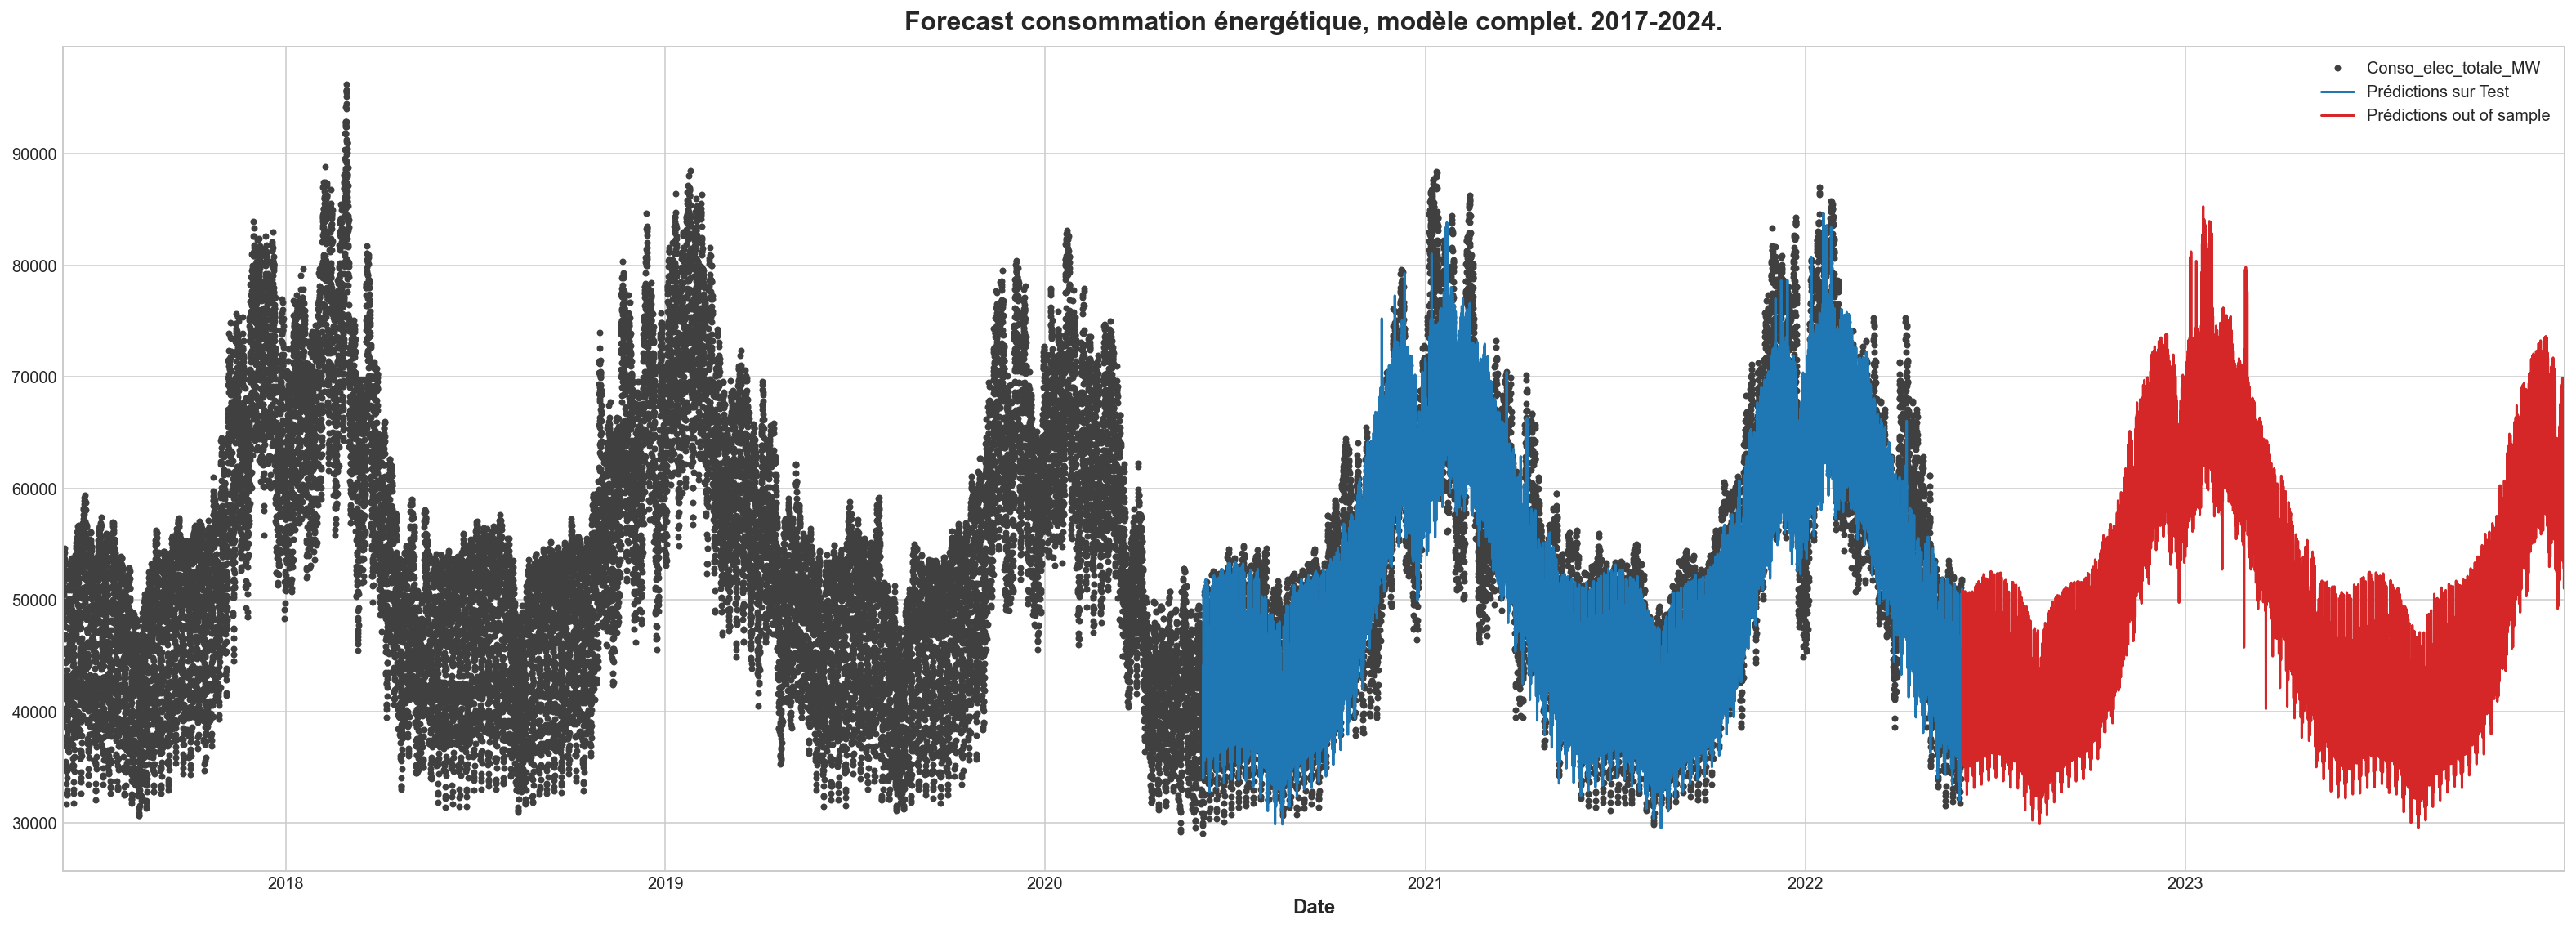

In [76]:
ax = df_resultat_viz["Conso_elec_totale_MW"].plot(color='0.25', style='.', title="Forecast consommation énergétique, modèle complet. 2017-2024.")
ax = df_entrainement_modele["Forecasted_values"].plot(ax=ax, label="Prédictions sur Test")
ax = df_predictions_modele["Forecasted_values"].plot(ax=ax, label="Prédictions out of sample", color='C3')
_ = ax.legend()

In [78]:
# Valeur maximale obtenue sur la période out of sample (de Juin 2022 à fin 2023)
index_conso_max = df_predictions_modele["Forecasted_values"].idxmax()
df_predictions_modele.loc[ df_predictions_modele.index == index_conso_max][['Forecasted_values']]

,Forecasted_values
Date,
2023-01-18 11:00:00+01:00,85279.196835


In [85]:
# Valeur maximale obtenue sur la période d'entraînement. Valeurs réelles mesurées.
index_conso_max2022 = df_entrainement_modele.loc [ df_entrainement_modele.index > "2022-01-01 00:00:00" ]["Conso_elec_totale_MW"].idxmax()
df_entrainement_modele.loc[ df_entrainement_modele.index == index_conso_max2022 ][['Conso_elec_totale_MW']]

,Conso_elec_totale_MW
Date,
2022-01-14 09:00:00+01:00,87025.0


In [82]:
# Identification des maximums annuels de consommation
# (ne pas tenir compte de la date index qui indique le dernier jour de l'année)
df_valeurs_max_annuelles = df_resultat.reset_index()\
    .groupby(pd.Grouper(key='Date', axis=0, freq='A'))\
    .max()

df_valeurs_max_annuelles[["Conso_elec_totale_MW"]].dropna()

,Conso_elec_totale_MW
Date,
2012-12-31 00:00:00+01:00,90741.0
2013-12-31 00:00:00+01:00,92629.0
2014-12-31 00:00:00+01:00,82607.0
2015-12-31 00:00:00+01:00,91934.0
2016-12-31 00:00:00+01:00,88731.0
2017-12-31 00:00:00+01:00,94236.0
2018-12-31 00:00:00+01:00,96272.0
2019-12-31 00:00:00+01:00,88453.0
2020-12-31 00:00:00+01:00,83161.0


#### Conclusion ###
<p>Le pic de consommation de l'année 2022 a déjà bien eu lieu le 14 Janvier dernier à 87 GW</p>
<p>Le prochain pic hivernal est estimé survenir <b>le 18 Janvier 2023, en fin de matinée, entre 11h et midi</b>.<br/>
Il devrait être de <b>85,2 GW, au minimum *</b>. Pour l'electricité uniquement.<br/>
*<i> Au minimum car notre modèle a tendance à sous estimer les pics</i></p>
<p>
C'est une estimation, si elle se vérifie, qui sera en nette baisse par rapport à l'année 2022.<br/>
Toutefois, elle reste plus elevée que l'hiver 2020, malgré une tendance de consommation énergétique ayant une tendance à la légère baisse.<br/></p>